In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pylab as plt
import seaborn as sns 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'gender_submission.csv', 'test.csv']


# Problem Statement
> Predicting who is going to survive the Titanic tragedy

## Load data

In [2]:
path = "../input/"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")
test_Id = test.pop('PassengerId')

## Data Cleaning and EDA

In [3]:
train.shape, test.shape

((891, 12), (418, 10))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## Missing Values

In [5]:
total = train.isnull().sum().sort_values(ascending = False)
percent = round(train.isnull().sum().sort_values(ascending = False)/len(train)*100, 2)
pd.concat([total, percent], axis = 1,keys= ['Total of NA values', 'Percent'])

,Total of NA values,Percent
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22
Fare,0,0.00
Ticket,0,0.00
Parch,0,0.00
SibSp,0,0.00
Sex,0,0.00
Name,0,0.00
Pclass,0,0.00


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 32.7+ KB


In [7]:
total = test.isnull().sum().sort_values(ascending = False)
percent = round(test.isnull().sum().sort_values(ascending = False)/len(test)*100, 2)
pd.concat([total, percent], axis = 1,keys= ['Total of NA values', 'Percent'])

,Total of NA values,Percent
Cabin,327,78.23
Age,86,20.57
Fare,1,0.24
Embarked,0,0.00
Ticket,0,0.00
Parch,0,0.00
SibSp,0,0.00
Sex,0,0.00
Name,0,0.00
Pclass,0,0.00


In [8]:
# drop the Cabin column becuse it's NaN values are more then 3/4 of the column 
# pd.Series(train.Cabin.unique()).is_unique
train.pop('Cabin')
test.pop('Cabin');

In [9]:
train.shape, test.shape

((891, 11), (418, 9))

In [10]:
# fill NAN with mean of age 
train.Age.fillna(train['Age'].mean(), inplace=True);

In [11]:
train.Age.isnull().sum()

0

## Investigate the Survival variable

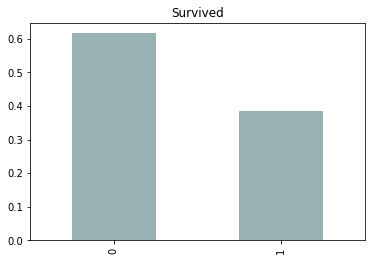

In [12]:
train.Survived.value_counts(normalize=True).plot(kind='bar', alpha=0.5, color='#336669' )
plt.title('Survived');

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


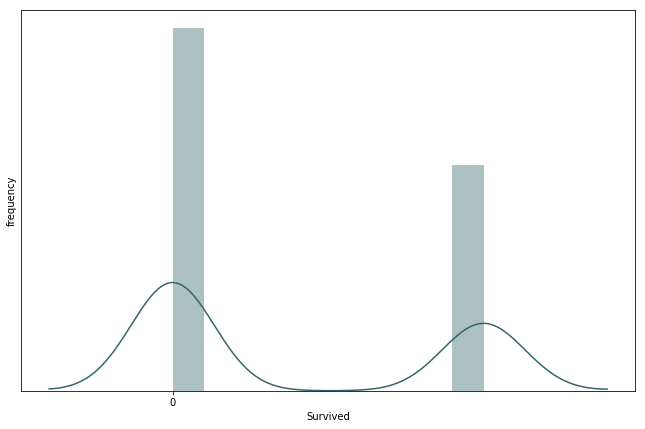

In [13]:
train = train[train.Survived < 1100]
plt.figure(figsize=[11,7])
plt.xticks(np.arange(0, 1200, step=100)) # better presentation for xticks
plt.yticks([]) # removes yticks
plt.ylabel('frequency')
sns.distplot(train.Survived, color='#336669', bins=10);

## Survival vs Age

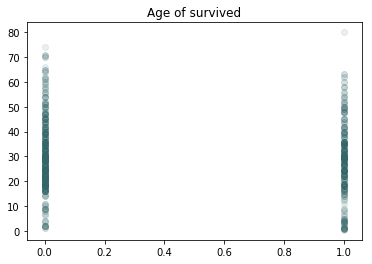

In [14]:
plt.scatter(train.Survived, train.Age, alpha=0.1, color='#336669')
plt.title('Age of survived');

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


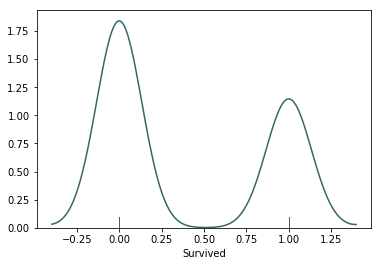

In [15]:
# distribution of Survived
ax = sns.distplot(train.Survived, rug=True, hist=False, color='#336669')

## Survival vs Sex

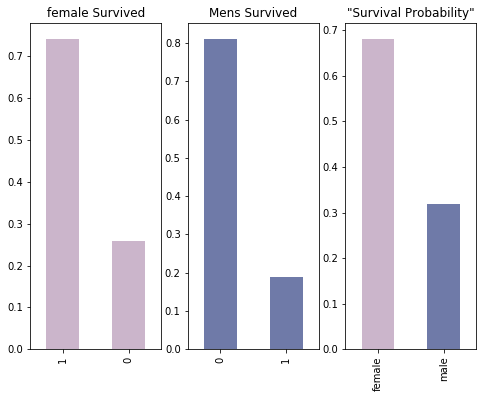

In [16]:
plt.figure(figsize=[8,6])
plt.subplot(1,3,1)
train.Survived[train.Sex == 'female'].value_counts(normalize=True).plot(kind='bar',color='#cbb5cb')
plt.title('female Survived');
plt.subplot(1,3,2)
train.Survived[train.Sex == 'male'].value_counts(normalize=True).plot(kind='bar', color ='#6f7aa8')
plt.title('Mens Survived');
plt.subplot(1,3,3)
train.Sex[train.Survived == 1].value_counts(normalize=True).plot(kind='bar', color =['#cbb5cb','#6f7aa8'])
plt.title('"Survival Probability"');

In [17]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


## Survival vs Pclass

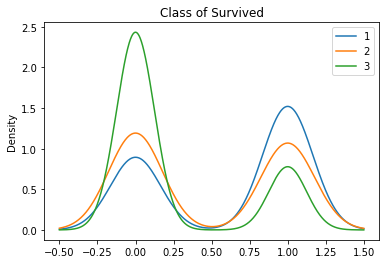

In [18]:
# Explore Pclass vs Survived
for i in [1,2,3]:
    train.Survived[train.Pclass == i].plot(kind='kde')
plt.title('Class of Survived')
plt.legend(('1','2','3'));

## Survival per Pclass and Sex

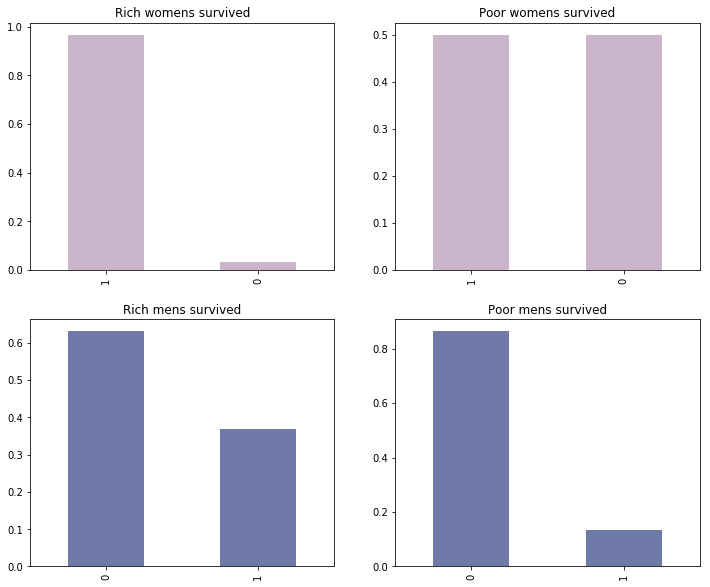

In [19]:
plt.figure(figsize=[12,10])
plt.subplot(2,2,1)
train.Survived[(train.Sex == 'female') & (train.Pclass== 1)].value_counts(normalize=True).plot(kind='bar', color ='#cbb5cb')
plt.title('Rich womens survived');
plt.subplot(2,2,2)
train.Survived[(train.Sex == 'female') & (train.Pclass== 3)].value_counts(normalize=True).plot(kind='bar', color ='#cbb5cb')
plt.title('Poor womens survived');
plt.subplot(2,2,3)
train.Survived[(train.Sex == 'male') & (train.Pclass== 1)].value_counts(normalize=True).plot(kind='bar', color ='#6f7aa8')
plt.title('Rich mens survived');
plt.subplot(2,2,4)
train.Survived[(train.Sex == 'male') & (train.Pclass== 3)].value_counts(normalize=True).plot(kind='bar', color ='#6f7aa8')
plt.title('Poor mens survived');

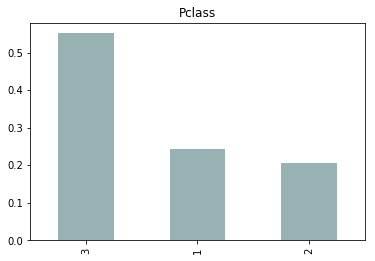

In [20]:
train.Pclass.value_counts(normalize=True).plot(kind='bar',alpha=0.5, color='#336669')
plt.title('Pclass');

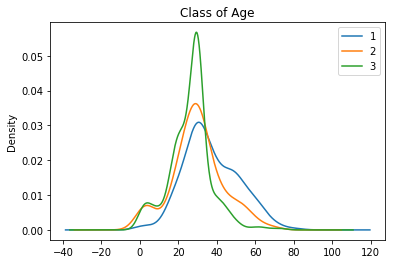

In [21]:
# avg of ages related of how can spent money to puy VIP class
for i in [1,2,3]:
    train.Age[train.Pclass == i].plot(kind='kde')
plt.title('Class of Age')
plt.legend(('1','2','3'));

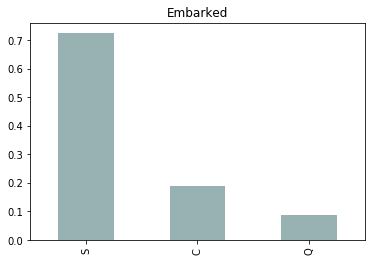

In [22]:
# where the titanic stop to take a passenger
train.Embarked.value_counts(normalize=True).plot(kind='bar', alpha=0.5, color='#336669')
plt.title('Embarked');

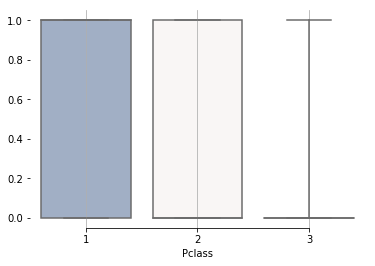

In [23]:
#  Pclass vs Survived by Sex
ax =sns.boxplot(x="Pclass", y="Survived", data=train,
            whis="range", palette="vlag")

ax.xaxis.grid(True)
ax = ax.set(ylabel="")
sns.despine(trim=True, left=True);

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


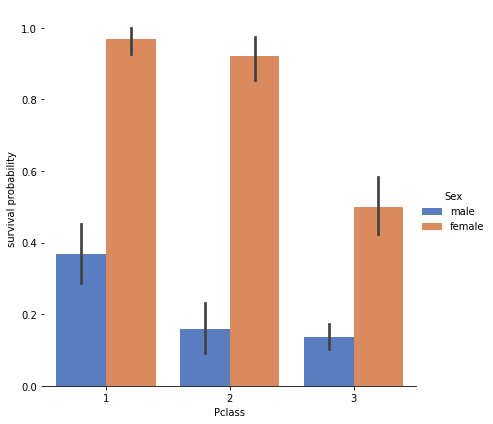

In [24]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted" )
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [25]:
# now fill the NaN values in Embarked column with the mode scince it is only 2 values
mode_value = train['Embarked'].mode()
# mode_value[0]
train['Embarked'].fillna(mode_value[0], inplace=True);
train.iloc[61], train.iloc[829]

(PassengerId                     62
 Survived                         1
 Pclass                           1
 Name           Icard, Miss. Amelie
 Sex                         female
 Age                             38
 SibSp                            0
 Parch                            0
 Ticket                      113572
 Fare                            80
 Embarked                         S
 Name: 61, dtype: object,
 PassengerId                                          830
 Survived                                               1
 Pclass                                                 1
 Name           Stone, Mrs. George Nelson (Martha Evelyn)
 Sex                                               female
 Age                                                   62
 SibSp                                                  0
 Parch                                                  0
 Ticket                                            113572
 Fare                                                  8

In [26]:
test[test.Fare.isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
152,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


In [27]:
# fill NaN value with the mean of the Pclass 3 which the missing value belong to 
mean_value = test.groupby('Pclass')['Fare'].mean()
# mean_value[3]
test.Fare.fillna(mean_value[3], inplace=True)
test.iloc[152]

Pclass                       3
Name        Storey, Mr. Thomas
Sex                       male
Age                       60.5
SibSp                        0
Parch                        0
Ticket                    3701
Fare                   12.4597
Embarked                     S
Name: 152, dtype: object

In [28]:
# Drop all the unique columns scince it can not contribute with the surviving chance
# such as Name and ticket 
train.drop(['Name', 'Ticket'],axis=1, inplace=True)|
test.drop(['Name', 'Ticket'],axis=1, inplace=True)

SyntaxError: invalid syntax (<ipython-input-28-fbcc91dee840>, line 3)

In [29]:
train.shape, test.shape

((891, 11), (418, 9))

In [30]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [31]:
# convert the Sex values into 0 for female and 1 for male inorder to show in the heatmap
train['Sex'] = train['Sex'].map({'male':1, 'female':0})
test['Sex'] = test['Sex'].map({'male':1, 'female':0})

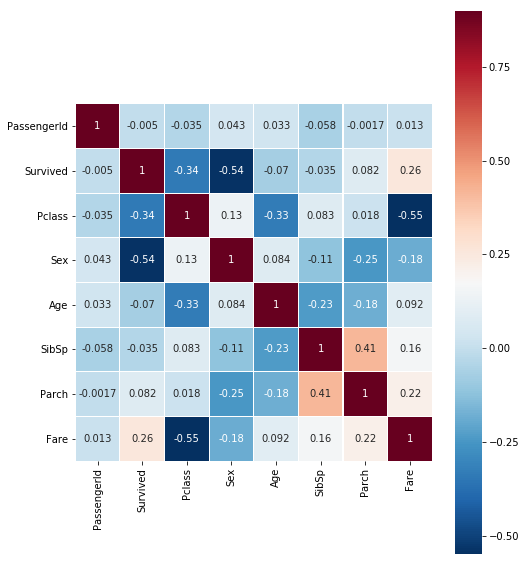

In [32]:
plt.figure(figsize=(8,10))
sns.heatmap(train.corr(), 
            annot=True,
            #mask = mask,
            cmap = 'RdBu_r',
            linewidths=0.1, 
            linecolor='white',
            vmax = .9,
            square=True);

In [33]:
survived_summary = train.groupby("Survived")
survived_summary.mean().reset_index()

,Survived,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,447.016393,2.531876,0.852459,30.415100,0.553734,0.329690,22.117887
1,1,444.368421,1.950292,0.318713,28.549778,0.473684,0.464912,48.395408


In [34]:
y = train.pop('Survived')

In [35]:
comb = pd.concat([train,test])
train.shape, test.shape, comb.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


((891, 10), (418, 9), (1309, 10))

In [36]:
comb = pd.get_dummies(comb, drop_first=False)
train.shape, test.shape, comb.shape

((891, 10), (418, 9), (1309, 2246))

In [37]:
train = comb.iloc[:len(train),:]
test = comb.iloc[len(train):,:]
train.shape, test.shape, comb.shape

((891, 2246), (418, 2246), (1309, 2246))

In [38]:
train.head()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Embarked_C,Embarked_Q,Embarked_S,"Name_Abbing, Mr. Anthony","Name_Abbott, Master. Eugene Joseph","Name_Abbott, Mr. Rossmore Edward","Name_Abbott, Mrs. Stanton (Rosa Hunt)","Name_Abelseth, Miss. Karen Marie","Name_Abelseth, Mr. Olaus Jorgensen","Name_Abelson, Mr. Samuel","Name_Abelson, Mrs. Samuel (Hannah Wizosky)","Name_Abrahamsson, Mr. Abraham August Johannes","Name_Abrahim, Mrs. Joseph (Sophie Halaut Easu)","Name_Adahl, Mr. Mauritz Nils Martin","Name_Adams, Mr. John","Name_Ahlin, Mrs. Johan (Johanna Persdotter Larsson)","Name_Aks, Master. Philip Frank","Name_Aks, Mrs. Sam (Leah Rosen)","Name_Albimona, Mr. Nassef Cassem","Name_Aldworth, Mr. Charles Augustus","Name_Alexander, Mr. William","Name_Alhomaki, Mr. Ilmari Rudolf","Name_Ali, Mr. Ahmed","Name_Ali, Mr. William","Name_Allen, Miss. Elisabeth Walton","Name_Allen, Mr. William Henry","Name_Allison, Master. Hudson Trevor","Name_Allison, Miss. Helen Loraine","Name_Allison, Mr. Hudson Joshua Creighton","Name_Allison, Mrs. Hudson J C (Bessie Waldo Daniels)","Name_Allum, Mr. Owen George","Name_Andersen, Mr. Albert Karvin","Name_Andersen-Jensen, Miss. Carla Christine Nielsine",...,Ticket_SOTON/OQ 3101316,Ticket_SOTON/OQ 3101317,Ticket_SOTON/OQ 392076,Ticket_SOTON/OQ 392082,Ticket_SOTON/OQ 392083,Ticket_SOTON/OQ 392086,Ticket_SOTON/OQ 392089,Ticket_SOTON/OQ 392090,Ticket_STON/O 2. 3101268,Ticket_STON/O 2. 3101269,Ticket_STON/O 2. 3101273,Ticket_STON/O 2. 3101274,Ticket_STON/O 2. 3101275,Ticket_STON/O 2. 3101280,Ticket_STON/O 2. 3101285,Ticket_STON/O 2. 3101286,Ticket_STON/O 2. 3101288,Ticket_STON/O 2. 3101289,Ticket_STON/O 2. 3101291,Ticket_STON/O 2. 3101292,Ticket_STON/O 2. 3101293,Ticket_STON/O 2. 3101294,Ticket_STON/O2. 3101270,Ticket_STON/O2. 3101271,Ticket_STON/O2. 3101279,Ticket_STON/O2. 3101282,Ticket_STON/O2. 3101283,Ticket_STON/O2. 3101290,Ticket_STON/OQ. 369943,Ticket_SW/PP 751,Ticket_W./C. 14258,Ticket_W./C. 14260,Ticket_W./C. 14263,Ticket_W./C. 14266,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735
0,22.0,7.2500,0,1.0,3,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,38.0,71.2833,0,2.0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,26.0,7.9250,0,3.0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,35.0,53.1000,0,4.0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,35.0,8.0500,0,5.0,3,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Preprocessing and Modeling¶

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, y)
headers = X_train.columns

In [40]:
# prepare data
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)
test_ss = ss.transform(test)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [41]:
pd.DataFrame(X_train_ss, columns=headers).head()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Embarked_C,Embarked_Q,Embarked_S,"Name_Abbing, Mr. Anthony","Name_Abbott, Master. Eugene Joseph","Name_Abbott, Mr. Rossmore Edward","Name_Abbott, Mrs. Stanton (Rosa Hunt)","Name_Abelseth, Miss. Karen Marie","Name_Abelseth, Mr. Olaus Jorgensen","Name_Abelson, Mr. Samuel","Name_Abelson, Mrs. Samuel (Hannah Wizosky)","Name_Abrahamsson, Mr. Abraham August Johannes","Name_Abrahim, Mrs. Joseph (Sophie Halaut Easu)","Name_Adahl, Mr. Mauritz Nils Martin","Name_Adams, Mr. John","Name_Ahlin, Mrs. Johan (Johanna Persdotter Larsson)","Name_Aks, Master. Philip Frank","Name_Aks, Mrs. Sam (Leah Rosen)","Name_Albimona, Mr. Nassef Cassem","Name_Aldworth, Mr. Charles Augustus","Name_Alexander, Mr. William","Name_Alhomaki, Mr. Ilmari Rudolf","Name_Ali, Mr. Ahmed","Name_Ali, Mr. William","Name_Allen, Miss. Elisabeth Walton","Name_Allen, Mr. William Henry","Name_Allison, Master. Hudson Trevor","Name_Allison, Miss. Helen Loraine","Name_Allison, Mr. Hudson Joshua Creighton","Name_Allison, Mrs. Hudson J C (Bessie Waldo Daniels)","Name_Allum, Mr. Owen George","Name_Andersen, Mr. Albert Karvin","Name_Andersen-Jensen, Miss. Carla Christine Nielsine",...,Ticket_SOTON/OQ 3101316,Ticket_SOTON/OQ 3101317,Ticket_SOTON/OQ 392076,Ticket_SOTON/OQ 392082,Ticket_SOTON/OQ 392083,Ticket_SOTON/OQ 392086,Ticket_SOTON/OQ 392089,Ticket_SOTON/OQ 392090,Ticket_STON/O 2. 3101268,Ticket_STON/O 2. 3101269,Ticket_STON/O 2. 3101273,Ticket_STON/O 2. 3101274,Ticket_STON/O 2. 3101275,Ticket_STON/O 2. 3101280,Ticket_STON/O 2. 3101285,Ticket_STON/O 2. 3101286,Ticket_STON/O 2. 3101288,Ticket_STON/O 2. 3101289,Ticket_STON/O 2. 3101291,Ticket_STON/O 2. 3101292,Ticket_STON/O 2. 3101293,Ticket_STON/O 2. 3101294,Ticket_STON/O2. 3101270,Ticket_STON/O2. 3101271,Ticket_STON/O2. 3101279,Ticket_STON/O2. 3101282,Ticket_STON/O2. 3101283,Ticket_STON/O2. 3101290,Ticket_STON/OQ. 369943,Ticket_SW/PP 751,Ticket_W./C. 14258,Ticket_W./C. 14260,Ticket_W./C. 14263,Ticket_W./C. 14266,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735
0,-0.597200,-0.473832,-0.470318,-1.400924,0.837661,0.758599,-0.468240,-0.477432,-0.299537,0.605023,-0.03872,0.0,-0.03872,0.0,0.0,0.0,-0.03872,-0.03872,0.0,0.0,0.0,-0.03872,-0.03872,0.0,-0.03872,-0.03872,0.0,0.0,0.0,-0.03872,-0.03872,0.0,-0.03872,-0.03872,-0.03872,0.0,0.0,-0.03872,0.0,-0.03872,...,0.0,-0.03872,-0.03872,-0.03872,0.0,-0.03872,0.0,-0.03872,0.0,0.0,-0.03872,0.0,0.0,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,0.0,-0.03872,0.0,-0.03872,0.0,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,0.0,-0.03872,-0.03872,0.0,-0.038720,0.0,-0.03872,-0.0548,-0.03872,0.0,0.0,-0.0548
1,-0.827679,-0.449404,-0.470318,0.927466,0.837661,0.758599,-0.468240,-0.477432,-0.299537,0.605023,-0.03872,0.0,-0.03872,0.0,0.0,0.0,-0.03872,-0.03872,0.0,0.0,0.0,-0.03872,-0.03872,0.0,-0.03872,-0.03872,0.0,0.0,0.0,-0.03872,-0.03872,0.0,-0.03872,-0.03872,-0.03872,0.0,0.0,-0.03872,0.0,-0.03872,...,0.0,-0.03872,-0.03872,-0.03872,0.0,-0.03872,0.0,-0.03872,0.0,0.0,-0.03872,0.0,0.0,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,0.0,-0.03872,0.0,-0.03872,0.0,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,0.0,-0.03872,-0.03872,0.0,-0.038720,0.0,-0.03872,-0.0548,-0.03872,0.0,0.0,-0.0548
2,0.555193,0.434915,0.733407,-0.756493,-1.569038,0.758599,0.407906,-0.477432,-0.299537,0.605023,-0.03872,0.0,-0.03872,0.0,0.0,0.0,-0.03872,-0.03872,0.0,0.0,0.0,-0.03872,-0.03872,0.0,-0.03872,-0.03872,0.0,0.0,0.0,-0.03872,-0.03872,0.0,-0.03872,-0.03872,-0.03872,0.0,0.0,-0.03872,0.0,-0.03872,...,0.0,-0.03872,-0.03872,-0.03872,0.0,-0.03872,0.0,-0.03872,0.0,0.0,-0.03872,0.0,0.0,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,0.0,-0.03872,0.0,-0.03872,0.0,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,0.0,-0.03872,-0.03872,0.0,-0.038720,0.0,-0.03872,-0.0548,-0.03872,0.0,0.0,-0.0548
3,1.169803,0.079083,-0.470318,-0.407426,-1.569038,0.758599,-0.468240,-0.477432,-0.299537,0.605023,-0.03872,0.0,-0.03872,0.0,0.0,0.0,-0.03872,-0.03872,0.0,0.0,0.0,-0.

In [42]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_ss, y_train)
knn.score(X_test_ss, y_test)
# output file 
knn_pred = pd.DataFrame(knn.predict(X_test_ss))
knn_pred.columns=['Survived']
knn_out = pd.concat([test_Id, knn_pred], axis=1)
knn_out.to_csv(index=False);

In [43]:
from sklearn.linear_model import LogisticRegression
lreg = LogisticRegression()
lreg.fit(X_train_ss, y_train)
lreg.score(X_test_ss, y_test)
lreg_pred = pd.DataFrame(lreg.predict(X_test_ss))
lreg_pred.columns=['Survived']
lreg_out = pd.concat([test_Id, lreg_pred], axis=1)
lreg_out.to_csv(index=False);

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [44]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train_ss, y_train)
svm.score(X_test_ss, y_test)
svm_pred = pd.DataFrame(svm.predict(X_test_ss))
svm_pred.columns=['Survived']
svm_out = pd.concat([test_Id, svm_pred], axis=1)
svm_out.to_csv(index=False);

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## Evaluation and Conceptual Understanding

In [45]:
from sklearn.model_selection import cross_val_score


In [46]:
cv = cross_val_score(KNeighborsClassifier(), X_train_ss, y_train, cv=5)
cv.mean()

0.47920547637751093

In [47]:
cv = cross_val_score(LogisticRegression(), X_train_ss, y_train, cv=5)
cv.mean()

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

0.742554146560431

In [48]:
cv = cross_val_score(SVC(), X_train_ss, y_train, cv=5)
cv.mean()

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

0.6107956458309954

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.57      0.58      0.58       144
           1       0.21      0.20      0.21        79

   micro avg       0.45      0.45      0.45       223
   macro avg       0.39      0.39      0.39       223
weighted avg       0.44      0.45      0.45       223



In [50]:
print(classification_report(y_test, lreg_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       144
           1       0.75      0.59      0.66        79

   micro avg       0.78      0.78      0.78       223
   macro avg       0.77      0.74      0.75       223
weighted avg       0.78      0.78      0.78       223



In [51]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       144
           1       0.69      0.66      0.68        79

   micro avg       0.78      0.78      0.78       223
   macro avg       0.76      0.75      0.75       223
weighted avg       0.77      0.78      0.77       223



## Conclusion and Recommendations

Exclusing the columns with the missing data seems to effect the efficency of the production model, therefore another methods that deals with the missing data have to be taken into concediration.